Week 5: data import, cleaning, prep, examination, outliers, exploratory data analysis (distribution, etc.), a little PCA

In [9]:
import warnings
warnings.filterwarnings('ignore')  
import seaborn as sns

from pathlib import Path
file_loc = Path(r'C:\Users\hruss\OneDrive\Documents\GMU\Repositories\CDS303-F22\data')
print(file_loc.is_dir())

True


In [10]:
df = sns.load_dataset('taxis')
print(df.head())

                pickup              dropoff  passengers  distance  fare   tip  \
0  2019-03-23 20:21:09  2019-03-23 20:27:24           1      1.60   7.0  2.15   
1  2019-03-04 16:11:55  2019-03-04 16:19:00           1      0.79   5.0  0.00   
2  2019-03-27 17:53:01  2019-03-27 18:00:25           1      1.37   7.5  2.36   
3  2019-03-10 01:23:59  2019-03-10 01:49:51           1      7.70  27.0  6.15   
4  2019-03-30 13:27:42  2019-03-30 13:37:14           3      2.16   9.0  1.10   

   tolls  total   color      payment            pickup_zone  \
0    0.0  12.95  yellow  credit card        Lenox Hill West   
1    0.0   9.30  yellow         cash  Upper West Side South   
2    0.0  14.16  yellow  credit card          Alphabet City   
3    0.0  36.95  yellow  credit card              Hudson Sq   
4    0.0  13.40  yellow  credit card           Midtown East   

            dropoff_zone pickup_borough dropoff_borough  
0    UN/Turtle Bay South      Manhattan       Manhattan  
1  Upper West Side

In [11]:
df.columns

Index(['pickup', 'dropoff', 'passengers', 'distance', 'fare', 'tip', 'tolls',
       'total', 'color', 'payment', 'pickup_zone', 'dropoff_zone',
       'pickup_borough', 'dropoff_borough'],
      dtype='object')

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6433 entries, 0 to 6432
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   pickup           6433 non-null   object 
 1   dropoff          6433 non-null   object 
 2   passengers       6433 non-null   int64  
 3   distance         6433 non-null   float64
 4   fare             6433 non-null   float64
 5   tip              6433 non-null   float64
 6   tolls            6433 non-null   float64
 7   total            6433 non-null   float64
 8   color            6433 non-null   object 
 9   payment          6389 non-null   object 
 10  pickup_zone      6407 non-null   object 
 11  dropoff_zone     6388 non-null   object 
 12  pickup_borough   6407 non-null   object 
 13  dropoff_borough  6388 non-null   object 
dtypes: float64(5), int64(1), object(8)
memory usage: 703.7+ KB


In [13]:
#Count nulls, print only features with null values 
nulls = df.isnull().sum()
nulls
#print(nulls[nulls >= 1])

pickup              0
dropoff             0
passengers          0
distance            0
fare                0
tip                 0
tolls               0
total               0
color               0
payment            44
pickup_zone        26
dropoff_zone       45
pickup_borough     26
dropoff_borough    45
dtype: int64

In [14]:
#Since locations are very important to us, any row that is missing location information is of no use. What are the counts for 
#boroughs and zones?
print("Number of pickup boroughs:", len(df['pickup_borough'].unique()))
print("Number of pickup zones:", len(df['pickup_zone'].unique()))


Number of pickup boroughs: 5
Number of pickup zones: 195


In [15]:
#We have a lot more zones than boroughs, safe to say zones are nested in boroughs. 
#Question: if the row is missing borough, will it also be missing zone?
df_not_null_puzone = df[df['pickup_borough'].notnull()]
df_not_null_dozone = df[df['dropoff_borough'].notnull()]
print(df_not_null_puzone['pickup_zone'].isnull().sum())
print(df_not_null_dozone['dropoff_zone'].isnull().sum())

0
0


In [16]:
#OK, missing pickup boroughs also result in missing pickup zones. Since location is key, then we can drop any rows that are missing both
#pickup and dropoff boroughs because there's no chance of filling in the info using zone info. Note, we still might want rows that have 
#either pickup or dropoff borough, but not rows that are missing both.
df2 = df[df['pickup_borough'].notnull() | df['dropoff_borough'].notnull()]
nulls2 = df2.isnull().sum()
print(nulls2[nulls2 >= 1])

payment            44
pickup_zone         5
dropoff_zone       24
pickup_borough      5
dropoff_borough    24
dtype: int64


In [42]:
print(df2.head())

                pickup              dropoff  passengers  distance  fare   tip  \
0  2019-03-23 20:21:09  2019-03-23 20:27:24           1      1.60   7.0  2.15   
1  2019-03-04 16:11:55  2019-03-04 16:19:00           1      0.79   5.0  0.00   
2  2019-03-27 17:53:01  2019-03-27 18:00:25           1      1.37   7.5  2.36   
3  2019-03-10 01:23:59  2019-03-10 01:49:51           1      7.70  27.0  6.15   
4  2019-03-30 13:27:42  2019-03-30 13:37:14           3      2.16   9.0  1.10   

   tolls  total   color      payment            pickup_zone  \
0    0.0  12.95  yellow  credit card        Lenox Hill West   
1    0.0   9.30  yellow         cash  Upper West Side South   
2    0.0  14.16  yellow  credit card          Alphabet City   
3    0.0  36.95  yellow  credit card              Hudson Sq   
4    0.0  13.40  yellow  credit card           Midtown East   

            dropoff_zone pickup_borough dropoff_borough  
0    UN/Turtle Bay South      Manhattan       Manhattan  
1  Upper West Side

In [18]:
#Originally, we had 26 missing pickup boroughs, and 45 missing dropoff boroughs, now we're down to 5 and 24 respectively.
#We can still use this for studying tips based solely on pickup and dropoff, however we need to be mindful if we want to study
#entire trips (which we will at some point.)

#Next is payment type. In our case study, we'll determine if we actually need to keep it. Here, we're focused on how to keep and 
#prepare it in a useful way. We have quite a few missing values here. From here out we're using df2 which has filtered boroughs / zones.

In [19]:
#We can try grouping the data by pickup and/or dropoff locations, then pick the mode (most frequent) value for payment.
#We can also take a look at the class balance, and apportion the payment values to maintain the balance. So, if for example the overall
#balance of cash / credit is 20 / 80, then we may want to fill in the missing values the same way. Or, instead of looking a the balance across
#the overall dataset, we might look by grouping.
df2_notnull = df2[df2['payment'].notnull()]
print('Balance of payment feature overall')
print(df2_notnull['payment'].value_counts(normalize = True).to_frame())


Balance of payment feature overall
             payment
credit card  0.71608
cash         0.28392


In [46]:

print('Balance of payment feature by pickup borough')
print(df2_notnull.groupby('pickup_borough')['payment'].value_counts(normalize = True).to_frame())


Balance of payment feature by pickup borough
                             payment
pickup_borough payment              
Bronx          credit card  0.747475
               cash         0.252525
Brooklyn       credit card  0.686842
               cash         0.313158
Manhattan      credit card  0.733193
               cash         0.266807
Queens         credit card  0.590139
               cash         0.409861


In [45]:

print('Balance of payment feature by dropoff borough')
print(df2_notnull.groupby('dropoff_borough')['payment'].value_counts(normalize = True).to_frame())


Balance of payment feature by dropoff borough
                              payment
dropoff_borough payment              
Bronx           credit card  0.617647
                cash         0.382353
Brooklyn        credit card  0.692153
                cash         0.307847
Manhattan       credit card  0.737056
                cash         0.262944
Queens          credit card  0.569288
                cash         0.430712
Staten Island   credit card  1.000000


In [22]:
#We can see that some boroughs are closer to the 70/30 split, while others are much further away. Best thing to preserve the class balances
#would be to assign values based on the proportions in each borough. There is also a big difference between pickup and dropoff location
#proportions. So, which do we choose? Best would be to assign the values by entire trip (from / to). Remember we said we'd need to do 
#analysis based on entire trip? For this, we'll need to keep only the rows that have both pickup and dropoff locations. Doing this by borough
#(not zone) would be fine here.

df3 = df2[(df2['pickup_borough'].notnull()) & (df2['dropoff_borough'].notnull())]
nulls = df3.isnull().sum()
print(nulls[nulls >= 1])

payment    42
dtype: int64


In [23]:
df3_wasNull = df3
print(df3_wasNull['payment'].value_counts(normalize=True))
nulls1 = df3_wasNull.isnull().sum()
print(nulls1[nulls1 >= 1])

credit card    0.716922
cash           0.283078
Name: payment, dtype: float64
payment    42
dtype: int64


In [47]:
import numpy as np
for _, gdf in df3.groupby(['pickup_borough', 'dropoff_borough'])['payment']:
    vc = gdf.value_counts(normalize=True)
    df3.loc[gdf.loc[gdf.isna()].index, 'payment'] = (
        np.random.choice(vc.index, gdf.isna().sum(), p=vc)
    )
print(df3['payment'].value_counts(normalize=True).to_frame())

              payment
credit card  0.717374
cash         0.282626


In [25]:
df3.isnull().sum()

pickup             0
dropoff            0
passengers         0
distance           0
fare               0
tip                0
tolls              0
total              0
color              0
payment            0
pickup_zone        0
dropoff_zone       0
pickup_borough     0
dropoff_borough    0
dtype: int64

In [48]:
#Time to look at other aspects of the dataset. 
print(df3.describe())

        passengers     distance         fare          tip        tolls  \
count  6383.000000  6383.000000  6383.000000  6383.000000  6383.000000   
mean      1.540812     2.994479    12.873472     1.959723     0.314526   
std       1.205929     3.717136    10.718949     2.359509     1.368289   
min       0.000000     0.000000     1.000000     0.000000     0.000000   
25%       1.000000     0.990000     6.500000     0.000000     0.000000   
50%       1.000000     1.650000     9.500000     1.700000     0.000000   
75%       2.000000     3.200000    15.000000     2.790000     0.000000   
max       6.000000    36.700000   150.000000    23.190000    24.020000   

             total  
count  6383.000000  
mean     18.281059  
std      12.947807  
min       1.300000  
25%      10.800000  
50%      14.160000  
75%      20.300000  
max     174.820000  


In [27]:
#There are apparently trips with zero passengers that went zero distance. Let's take a look at those.
df3[df3['passengers'] == 0].shape

(96, 14)

In [28]:
#Holy cow, 96 rows are missing number of passengers. Is there a chance maybe they are delivering food?
#Let's wait on that decision for now. How about the trips with zero distance?
df3[df3['distance'] == 0].shape

(36, 14)

In [49]:
#Fewer trips with zero distance. This is an easy one to fix, too, and unlike number of passengers it is obviously an error.
#We can fix this in much the same way as we fixed the payment column: by grouping according to pickup and dropoff.
#First, I'd like to make sure that the distances are relatively consistent for trips.
#Another thing, I'd like to get a little more granular with the locations, so I'll try to use zones instead of boroughs.
df3_zeroDist = df3[df3['distance'] == 0]
print(df3_zeroDist.groupby(['pickup_zone', 'dropoff_zone'])['tip'].value_counts())

pickup_zone                     dropoff_zone                    tip  
Astoria                         Astoria                         0.00     2
Bushwick South                  Bushwick South                  0.00     1
Clinton East                    Clinton East                    12.21    1
Cobble Hill                     Cobble Hill                     0.00     1
Downtown Brooklyn/MetroTech     Downtown Brooklyn/MetroTech     0.00     1
Dyker Heights                   Dyker Heights                   0.00     1
East Chelsea                    East Chelsea                    0.00     1
Financial District North        World Trade Center              0.00     1
Flatbush/Ditmas Park            Flatbush/Ditmas Park            0.01     1
Fort Greene                     Fort Greene                     0.00     1
Garment District                Garment District                0.00     1
Hudson Sq                       Hudson Sq                       0.00     1
Hunts Point                   

In [50]:
#Odd, some of these trips have big tips, despite being in the same borough for pickup / dropoff. 
#For now, I might be inclined to drop these, or maybe assign them a 1/2 mile just so they're not zero.
#Let's just try one more thing: let's look at all instances where pickup zone does not equal dropoff zone.
df3_zeroDist_diffZone = df3_zeroDist[df3_zeroDist['pickup_zone'] != df3_zeroDist['dropoff_zone']]
print(df3_zeroDist_diffZone.groupby(['pickup_zone', 'dropoff_zone'])['tip'].value_counts())

pickup_zone               dropoff_zone           tip
Financial District North  World Trade Center     0.0    1
Parkchester               Flatbush/Ditmas Park   0.0    1
Seaport                   Battery Park City      0.0    1
Steinway                  Sunnyside              0.0    1
West Village              Upper East Side South  0.0    1
Name: tip, dtype: int64


In [51]:
#Steinway to Sunnyside is 2.5 miles, Parkchester to Ditmas Park is 20 miles. I think it is best to remove all of the zero
#distance occurrences since we cannot know for sure what the distance should be. Easiest way to do this is filter dataset
#such that minimum distance is greater than zero.
#In addition, we want to break up date and time into month of year, day of week, and hour of day. We do all this below:
import datetime as dt
from datetime import date
import pandas as pd

df4 = df3[(df3['distance'] != 0) & (df3['passengers'] != 0)]
print(df4.head())

                pickup              dropoff  passengers  distance  fare   tip  \
0  2019-03-23 20:21:09  2019-03-23 20:27:24           1      1.60   7.0  2.15   
1  2019-03-04 16:11:55  2019-03-04 16:19:00           1      0.79   5.0  0.00   
2  2019-03-27 17:53:01  2019-03-27 18:00:25           1      1.37   7.5  2.36   
3  2019-03-10 01:23:59  2019-03-10 01:49:51           1      7.70  27.0  6.15   
4  2019-03-30 13:27:42  2019-03-30 13:37:14           3      2.16   9.0  1.10   

   tolls  total   color      payment            pickup_zone  \
0    0.0  12.95  yellow  credit card        Lenox Hill West   
1    0.0   9.30  yellow         cash  Upper West Side South   
2    0.0  14.16  yellow  credit card          Alphabet City   
3    0.0  36.95  yellow  credit card              Hudson Sq   
4    0.0  13.40  yellow  credit card           Midtown East   

            dropoff_zone pickup_borough dropoff_borough  
0    UN/Turtle Bay South      Manhattan       Manhattan  
1  Upper West Side

In [52]:
#Now, let's break out the date / time column into day month year hour
#Day of week: Monday = 0, Tuesday = 1, Wednesday = 2, etc.
df4['pickup'] = pd.to_datetime(df4['pickup'], format = '%Y-%m-%d %H:%M:%S')
df4['Pday'] = df4['pickup'].dt.weekday
df4['Pmonth'] = df4['pickup'].dt.month
df4['Pyear'] = df4['pickup'].dt.year
df4['Phour'] = df4['pickup'].dt.hour
df4['dropoff'] = pd.to_datetime(df4['dropoff'], format = '%Y-%m-%d %H:%M:%S')
df4['Dday'] = df4['dropoff'].dt.weekday
df4['Dmonth'] = df4['dropoff'].dt.month
df4['Dyear'] = df4['dropoff'].dt.year
df4['Dhour'] = df4['dropoff'].dt.hour
df4.drop(['pickup', 'dropoff'], inplace = True, axis = 1)

print(df4.head())


   passengers  distance  fare   tip  tolls  total   color      payment  \
0           1      1.60   7.0  2.15    0.0  12.95  yellow  credit card   
1           1      0.79   5.0  0.00    0.0   9.30  yellow         cash   
2           1      1.37   7.5  2.36    0.0  14.16  yellow  credit card   
3           1      7.70  27.0  6.15    0.0  36.95  yellow  credit card   
4           3      2.16   9.0  1.10    0.0  13.40  yellow  credit card   

             pickup_zone           dropoff_zone pickup_borough  \
0        Lenox Hill West    UN/Turtle Bay South      Manhattan   
1  Upper West Side South  Upper West Side South      Manhattan   
2          Alphabet City           West Village      Manhattan   
3              Hudson Sq         Yorkville West      Manhattan   
4           Midtown East         Yorkville West      Manhattan   

  dropoff_borough  Pday  Pmonth  Pyear  Phour  Dday  Dmonth  Dyear  Dhour  
0       Manhattan     5       3   2019     20     5       3   2019     20  
1     

In [53]:
#Quick look to make sure everything looks good
print(df4.describe())

        passengers     distance         fare          tip        tolls  \
count  6252.000000  6252.000000  6252.000000  6252.000000  6252.000000   
mean      1.566219     3.011766    12.875187     1.956750     0.309623   
std       1.201209     3.722938    10.656627     2.346348     1.358912   
min       1.000000     0.010000     1.000000     0.000000     0.000000   
25%       1.000000     1.000000     6.500000     0.000000     0.000000   
50%       1.000000     1.660000     9.500000     1.700000     0.000000   
75%       2.000000     3.220000    15.000000     2.760000     0.000000   
max       6.000000    36.700000   150.000000    23.190000    24.020000   

             total         Pday       Pmonth   Pyear        Phour  \
count  6252.000000  6252.000000  6252.000000  6252.0  6252.000000   
mean     18.279819     3.164427     2.999840  2019.0    13.881638   
std      12.853383     1.912791     0.012647     0.0     6.068853   
min       1.300000     0.000000     2.000000  2019.0     

''

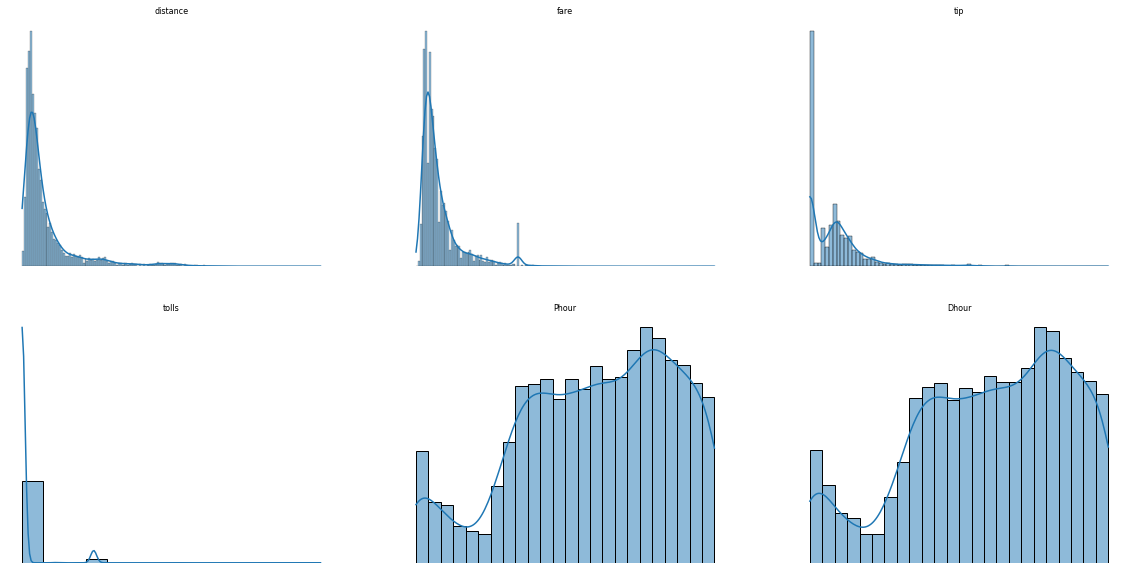

In [34]:
#So, doesn't look too bad except for a couple questions. The max dropoff month is 4, but the max pickup month is 3. Now, this is entirely
#possible if, let's say, the person was picked up at 11:59pm March 31 and dropped off 12:00am on April 1. 
#Another thing to note, we are only working with about two months of data here. Finally, looks like the average time of day
#for trips is 1300 or 1:00pm.
#Now, let's take a look at the distributions of the data, to see how 'normal' it is. We need to know for a variety of reasons, including
#whether or not to scale the data.
from matplotlib import pyplot as plt
f = plt.figure(figsize=(20,10))
f.tight_layout()
# Subplot 1
plt.subplot(2, 3, 1)
feature = 'distance'
hist = sns.histplot(data=df4, x=feature, label=feature, kde=True)
plt.title(feature, fontsize=8)
plt.axis('off')
# Subplot 2
plt.subplot(2, 3, 2)
feature = 'fare'
hist = sns.histplot(data=df4, x=feature, label=feature, kde=True)
plt.title(feature, fontsize=8)
plt.axis('off')
# Subplot 3
plt.subplot(2, 3, 3)
feature = 'tip'
hist = sns.histplot(data=df4, x=feature, label=feature, kde=True)
plt.title(feature, fontsize=8)
plt.axis('off')
# Subplot 4
plt.subplot(2, 3, 4)
feature = 'tolls'
hist = sns.histplot(data=df4, x=feature, label=feature, kde=True)
plt.title(feature, fontsize=8)
plt.axis('off')
# Subplot 5
plt.subplot(2, 3, 5)
feature = 'Phour'
hist = sns.histplot(data=df4, x=feature, label=feature, kde=True)
plt.title(feature, fontsize=8)
plt.axis('off')
# Subplot 6
plt.subplot(2, 3, 6)
feature = 'Dhour'
hist = sns.histplot(data=df4, x=feature, label=feature, kde=True)
plt.title(feature, fontsize=8)
plt.axis('off')
;


In [54]:
#As we step through the histograms above, most of the features in this dataset are not normally distributed. Due to that, and the
#fact that we're comparing features with different scales, we would benefit from normalizing columns.
#First, let's create some new columns (concatenate pickup and dropoff boroughs)
df4['trip'] = df4['pickup_borough'] + df4['dropoff_borough']
print(df4.head())

   passengers  distance  fare   tip  tolls  total   color      payment  \
0           1      1.60   7.0  2.15    0.0  12.95  yellow  credit card   
1           1      0.79   5.0  0.00    0.0   9.30  yellow         cash   
2           1      1.37   7.5  2.36    0.0  14.16  yellow  credit card   
3           1      7.70  27.0  6.15    0.0  36.95  yellow  credit card   
4           3      2.16   9.0  1.10    0.0  13.40  yellow  credit card   

             pickup_zone           dropoff_zone  ... dropoff_borough Pday  \
0        Lenox Hill West    UN/Turtle Bay South  ...       Manhattan    5   
1  Upper West Side South  Upper West Side South  ...       Manhattan    0   
2          Alphabet City           West Village  ...       Manhattan    2   
3              Hudson Sq         Yorkville West  ...       Manhattan    6   
4           Midtown East         Yorkville West  ...       Manhattan    5   

   Pmonth  Pyear  Phour  Dday  Dmonth  Dyear  Dhour                trip  
0       3   2019  

In [55]:
#Now, let's convert the rest of the categorical columns to numnbers (color, payment, pickup/dropoff borough).
#Because there are so many zones, we'll skip encoding those for now and just drop them.
from sklearn.preprocessing import OneHotEncoder 
cat_encoder = OneHotEncoder() 
df4_hot = cat_encoder.fit_transform(df4[['color', 'payment', 'trip', 'pickup_borough', 'dropoff_borough']]) 
enc_names = cat_encoder.get_feature_names_out()
df4_hotdf = pd.DataFrame(df4_hot.todense(), columns = enc_names)
df4_tr = pd.merge(df4_hotdf, df4.drop(['color', 'payment', 'pickup_borough', 'dropoff_borough', 'pickup_zone', 'dropoff_zone', 'trip'], axis=1), left_index=True, right_index=True)
df4_tr.drop(['payment_cash', 'color_green'], inplace = True, axis = 1)
print(df4_tr.head())


   color_yellow  payment_credit card  trip_BronxBronx  trip_BronxBrooklyn  \
0           1.0                  1.0              0.0                 0.0   
1           1.0                  0.0              0.0                 0.0   
2           1.0                  1.0              0.0                 0.0   
3           1.0                  1.0              0.0                 0.0   
4           1.0                  1.0              0.0                 0.0   

   trip_BronxManhattan  trip_BronxQueens  trip_BrooklynBronx  \
0                  0.0               0.0                 0.0   
1                  0.0               0.0                 0.0   
2                  0.0               0.0                 0.0   
3                  0.0               0.0                 0.0   
4                  0.0               0.0                 0.0   

   trip_BrooklynBrooklyn  trip_BrooklynManhattan  trip_BrooklynQueens  ...  \
0                    0.0                     0.0                  0.0  ...

In [37]:
#What columns are we left with?
df4_tr.columns

Index(['color_yellow', 'payment_credit card', 'trip_BronxBronx',
       'trip_BronxBrooklyn', 'trip_BronxManhattan', 'trip_BronxQueens',
       'trip_BrooklynBronx', 'trip_BrooklynBrooklyn', 'trip_BrooklynManhattan',
       'trip_BrooklynQueens', 'trip_ManhattanBronx', 'trip_ManhattanBrooklyn',
       'trip_ManhattanManhattan', 'trip_ManhattanQueens',
       'trip_ManhattanStaten Island', 'trip_QueensBronx',
       'trip_QueensBrooklyn', 'trip_QueensManhattan', 'trip_QueensQueens',
       'pickup_borough_Bronx', 'pickup_borough_Brooklyn',
       'pickup_borough_Manhattan', 'pickup_borough_Queens',
       'dropoff_borough_Bronx', 'dropoff_borough_Brooklyn',
       'dropoff_borough_Manhattan', 'dropoff_borough_Queens',
       'dropoff_borough_Staten Island', 'passengers', 'distance', 'fare',
       'tip', 'tolls', 'total', 'Pday', 'Pmonth', 'Pyear', 'Phour', 'Dday',
       'Dmonth', 'Dyear', 'Dhour'],
      dtype='object')

In [38]:
#Since our data is from only a couple months in one year, might as well drop month and year completely. In addition, we'll drop
#Dropoff_hour because it is correlated with, and less important than, pickup hour.
df4_tr.drop(['Pmonth', 'Pyear', 'Dday', 'Dmonth', 'Dyear', 'Dhour'], inplace=True, axis=1)
df4_tr.columns

Index(['color_yellow', 'payment_credit card', 'trip_BronxBronx',
       'trip_BronxBrooklyn', 'trip_BronxManhattan', 'trip_BronxQueens',
       'trip_BrooklynBronx', 'trip_BrooklynBrooklyn', 'trip_BrooklynManhattan',
       'trip_BrooklynQueens', 'trip_ManhattanBronx', 'trip_ManhattanBrooklyn',
       'trip_ManhattanManhattan', 'trip_ManhattanQueens',
       'trip_ManhattanStaten Island', 'trip_QueensBronx',
       'trip_QueensBrooklyn', 'trip_QueensManhattan', 'trip_QueensQueens',
       'pickup_borough_Bronx', 'pickup_borough_Brooklyn',
       'pickup_borough_Manhattan', 'pickup_borough_Queens',
       'dropoff_borough_Bronx', 'dropoff_borough_Brooklyn',
       'dropoff_borough_Manhattan', 'dropoff_borough_Queens',
       'dropoff_borough_Staten Island', 'passengers', 'distance', 'fare',
       'tip', 'tolls', 'total', 'Pday', 'Phour'],
      dtype='object')

In [39]:
df4_tr.columns = ['c_yellow', 'p_credit', 't_BronBron', 't_BronBroo', 't_BronManh', 't_BronQuee', 't_BrooBron', 't_BrooBroo', 't_BrooManh', 
    't_BrooQuee', 't_ManhBron', 't_ManhBroo', 't_ManhManh', 't_ManhQuee', 't_ManhStat', 't_QueeBron', 't_QueeBroo', 't_QueeManh', 't_QueeQuee',
    'p_Bron', 'p_Broo', 'p_Manh', 'p_Quee', 'd_Bron', 'd_Broo', 'd_Manh', 'd_Quee', 'd_Stat',
    'pass', 'dist', 'fare', 'tip', 'tolls', 'total', 'p_day', 'p_hour']
df4_tr.columns

Index(['c_yellow', 'p_credit', 't_BronBron', 't_BronBroo', 't_BronManh',
       't_BronQuee', 't_BrooBron', 't_BrooBroo', 't_BrooManh', 't_BrooQuee',
       't_ManhBron', 't_ManhBroo', 't_ManhManh', 't_ManhQuee', 't_ManhStat',
       't_QueeBron', 't_QueeBroo', 't_QueeManh', 't_QueeQuee', 'p_Bron',
       'p_Broo', 'p_Manh', 'p_Quee', 'd_Bron', 'd_Broo', 'd_Manh', 'd_Quee',
       'd_Stat', 'pass', 'dist', 'fare', 'tip', 'tolls', 'total', 'p_day',
       'p_hour'],
      dtype='object')

In [56]:
#OK, remember that most features in our dataset were skewed. Scaling helps with that. 
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df4_norm = scaler.fit_transform(df4_tr)
norm_names = scaler.get_feature_names_out()
df4_normdf = pd.DataFrame(df4_norm, columns = norm_names)
print(df4_normdf.head())

   color_yellow  payment_credit card  trip_BronxBronx  trip_BronxBrooklyn  \
0           1.0                  1.0              0.0                 0.0   
1           1.0                  0.0              0.0                 0.0   
2           1.0                  1.0              0.0                 0.0   
3           1.0                  1.0              0.0                 0.0   
4           1.0                  1.0              0.0                 0.0   

   trip_BronxManhattan  trip_BronxQueens  trip_BrooklynBronx  \
0                  0.0               0.0                 0.0   
1                  0.0               0.0                 0.0   
2                  0.0               0.0                 0.0   
3                  0.0               0.0                 0.0   
4                  0.0               0.0                 0.0   

   trip_BrooklynBrooklyn  trip_BrooklynManhattan  trip_BrooklynQueens  ...  \
0                    0.0                     0.0                  0.0  ...

In [41]:
#OK, the basic dataset is ready.
df4_normdf.to_csv(file_loc/"Week5_output.csv")